# Imports

In [1]:
import wget
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

# Load Data

In [2]:
url = 'https://raw.githubusercontent.com/GLambard/Molecules_Dataset_Collection/master/latest/clintox.csv'

wget.download(url, 'clintox.csv')

'clintox (1).csv'

In [3]:
tox_df = pd.read_csv("clintox.csv", index_col=0)
tox_df.head()

,smiles,FDA_APPROVED,CT_TOX
0,COCCOC(=O)NCCCC[C@@H](C=O)NC(=O)OCCOC,1,0
1,Cl[C@H]1[C@H](Cl)[C@@H](Cl)[C@@H](Cl)[C@H](Cl)...,1,0
2,O=C([O-])[C@@H](O)[C@@H](O)[C@H](O)[C@@H](O)C(...,1,0
3,[H]/[NH+]=C(\N)C1=CC(=O)/C(=C\C=C2:C:C:C(=C(N)...,1,0
4,[H]/[NH+]=C(\N)C1:C:C:C(OCCCCCOC2:C:C:C(/C(N)=...,1,0


# Nulls and Duplicates

In [4]:
def summary_stats(df):
    print(f"length of dataframe: {len(df)}\n")
    print(f"number of nulls in the columns:\n{df.isnull().sum()}\n")
    print(f"number of unique values in the columns:")
    for column in df.columns:
        print(f"{column}: {df[column].nunique()}")
    print("\n")

In [5]:
summary_stats(tox_df)

length of dataframe: 1484

number of nulls in the columns:
smiles          6
FDA_APPROVED    0
CT_TOX          0
dtype: int64

number of unique values in the columns:
smiles: 1459
FDA_APPROVED: 2
CT_TOX: 2




In [6]:
tox_df = tox_df.drop_duplicates()
tox_df = tox_df.dropna()

summary_stats(tox_df)

length of dataframe: 1478

number of nulls in the columns:
smiles          0
FDA_APPROVED    0
CT_TOX          0
dtype: int64

number of unique values in the columns:
smiles: 1459
FDA_APPROVED: 2
CT_TOX: 2




In [7]:
tox_df[tox_df["smiles"].duplicated(keep=False)]

,smiles,FDA_APPROVED,CT_TOX
13,CC(C)C[C@H](NC(=O)[C@H](CC1:C:C:C:C:C:1)NC(=O)...,1,0
14,CC(C)C[C@H](NC(=O)[C@H](CC1:C:C:C:C:C:1)NC(=O)...,0,1
84,NC1:N:C:N([C@H]2C[C@H](O)[C@@H](CO)O2):C(=O):N:1,0,1
98,NC1:N:C(=S):C2:[NH]:C:N:C:2:[NH]:1,1,0
99,S=C1:N:C:[NH]:C2:N:C:[NH]:C:1:2,1,0
110,O=C1:[NH]:C:C(F):C(=O):[NH]:1,1,0
115,O=C1:[NH]:C:C(F):C(=O):[NH]:1,0,1
211,O=C1CCC(N2C(=O)C3:C:C:C:C:C:3C2=O)C(=O)N1,0,1
212,NC1:C:C:C:C2:C:1CN(C1CCC(=O)NC1=O)C2=O,0,1
219,NC1:C:C:C:C2:C:1CN(C1CCC(=O)NC1=O)C2=O,1,0


All of the duplicates are self-contradictory.
One entry says FDA_APPROVED and not CT_TOX, and the other says not FDA_APPROVED and CT_TOX.
For the purposes of this exercise, I will change both entries, in case of duplication, to not FDA_APPROVED and CT_TOX.

In [8]:
tox_df["duplicated"] = tox_df["smiles"].duplicated(keep=False)

def process_duplicates(x):
    if x["duplicated"]:
        x["FDA_APPROVED"] = 0
        x["CT_TOX"] = 1
    return x
tox_df = tox_df.apply(lambda x: process_duplicates(x), axis=1)
tox_df = tox_df.drop_duplicates(keep="first")

summary_stats(tox_df)

length of dataframe: 1459

number of nulls in the columns:
smiles          0
FDA_APPROVED    0
CT_TOX          0
duplicated      0
dtype: int64

number of unique values in the columns:
smiles: 1459
FDA_APPROVED: 2
CT_TOX: 2
duplicated: 2




# Vector Representation

In [9]:
# Define the SMILES notation for your molecule
smiles = "CCO"  # Ethanol

# Parse the SMILES to create an RDKit molecule object
mol = Chem.MolFromSmiles(smiles)

# Check if the molecule was successfully created
if mol is not None:
    # Generate a Morgan fingerprint for the molecule
    radius = 2  # Radius of the fingerprint
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius)

    # Convert the fingerprint to a NumPy array
    fp_array = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, fp_array)

    # Now, 'fp_array' contains the binary vector representation of the molecule
    print(f"Morgan fingerprint vector (length {len(fp_array)}):")
    print(fp_array)
else:
    print("Invalid SMILES notation. Could not create a molecule object.")


Morgan fingerprint vector (length 2048):
[0. 0. 0. ... 0. 0. 0.]


In [10]:
def smiles_to_fp_array(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            radius = 2
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius)
            fp_array = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, fp_array)
            return fp_array
        else:
            print(f"No molecule for SMILES {smiles}")
            return np.zeros((2048,))
    except Exception as e:
        print(e)
        print(f"Error for SMILES {smiles}")

In [11]:
tox_df["fp_array"] = tox_df["smiles"].apply(lambda x: smiles_to_fp_array(x))
tox_df.head()

,smiles,FDA_APPROVED,CT_TOX,duplicated,fp_array
0,COCCOC(=O)NCCCC[C@@H](C=O)NC(=O)OCCOC,1,0,False,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Cl[C@H]1[C@H](Cl)[C@@H](Cl)[C@@H](Cl)[C@H](Cl)...,1,0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,O=C([O-])[C@@H](O)[C@@H](O)[C@H](O)[C@@H](O)C(...,1,0,False,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,[H]/[NH+]=C(\N)C1=CC(=O)/C(=C\C=C2:C:C:C(=C(N)...,1,0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,[H]/[NH+]=C(\N)C1:C:C:C(OCCCCCOC2:C:C:C(/C(N)=...,1,0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Summary Stats

In [12]:
min_smiles_len = len(tox_df.iloc[0,0])
max_smiles_len = len(tox_df.iloc[0,0])
min_fp_array_len = len(tox_df.iloc[0,4])
max_fp_array_len = len(tox_df.iloc[0,4])
for row in tox_df.iterrows():
    if len(row[1]["smiles"]) < min_smiles_len:
        min_smiles_len = len(row[1]["smiles"])
    if len(row[1]["smiles"]) > max_smiles_len:
        max_smiles_len = len(row[1]["smiles"])
    if len(row[1]["fp_array"]) < min_fp_array_len:
        min_fp_array_len = len(row[1]["fp_array"])
    if len(row[1]["fp_array"]) > max_fp_array_len:
        max_fp_array_len = len(row[1]["fp_array"])

print(f"The shortest length of the SMILES is {min_smiles_len}\n"
      f"The longest length of the SMILES is {max_smiles_len}\n"
      f"The shortest length of the fingerprint array is {min_fp_array_len}\n"
      f"The longest length of the fingerprint array is {max_fp_array_len}\n")

The shortest length of the SMILES is 2
The longest length of the SMILES is 358
The shortest length of the fingerprint array is 2048
The longest length of the fingerprint array is 2048



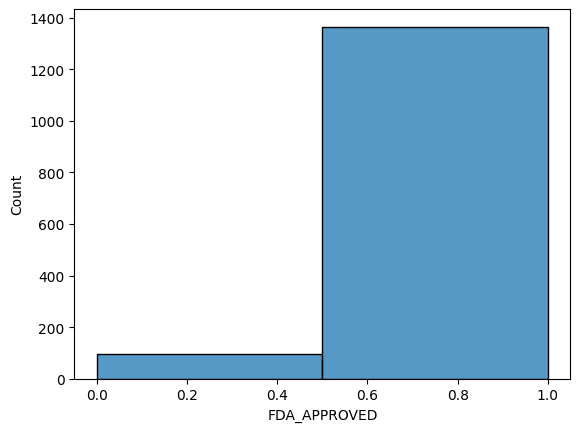

In [13]:
sns.histplot(tox_df["FDA_APPROVED"], bins = 2);

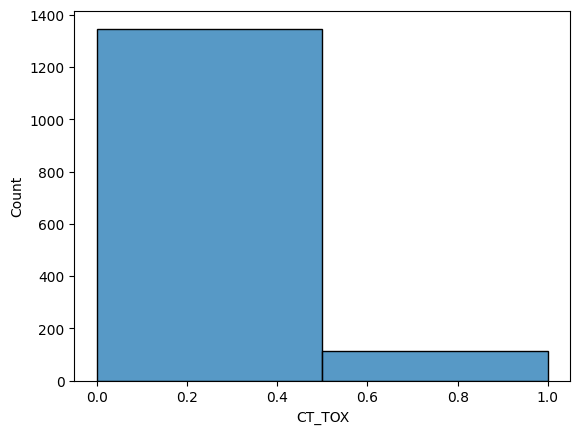

In [14]:
sns.histplot(tox_df["CT_TOX"], bins = 2);

# Train-Val-Test Split

In [15]:
def expand_array_to_columns(row):
    return pd.Series(row['fp_array'])

# Apply the function to each row in the DataFrame
expanded_df = tox_df.apply(expand_array_to_columns, axis=1)

# Rename the columns with numbers from 0 to 2047
expanded_df.columns = range(2048)

# Concatenate the expanded DataFrame with the original DataFrame
tox_df = pd.concat([tox_df, expanded_df], axis=1)

# Display the resulting DataFrame
tox_df

,smiles,FDA_APPROVED,CT_TOX,duplicated,fp_array,0,1,2,3,4,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,COCCOC(=O)NCCCC[C@@H](C=O)NC(=O)OCCOC,1,0,False,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cl[C@H]1[C@H](Cl)[C@@H](Cl)[C@@H](Cl)[C@H](Cl)...,1,0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,O=C([O-])[C@@H](O)[C@@H](O)[C@H](O)[C@@H](O)C(...,1,0,False,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,[H]/[NH+]=C(\N)C1=CC(=O)/C(=C\C=C2:C:C:C(=C(N)...,1,0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,[H]/[NH+]=C(\N)C1:C:C:C(OCCCCCOC2:C:C:C(/C(N)=...,1,0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,O=[Si](O)O,1,0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1480,O=[Ti]=O,1,0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1481,O=[Zn],1,0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1482,[O-][Cl+3]([O-])([O-])O,1,0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# split your data in train/val/test sets with 60%/20%/20% distribution

p1 = 0.6  # Training
p2 = 0.2  # Validation
p3 = 0.2  # Test

df_full_train, df_test = train_test_split(tox_df, test_size=p3, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=p2 / (1 - p3), random_state=42)

print(len(df_train), len(df_val), len(df_test))

y_train = df_train["CT_TOX"].values
y_val = df_val["CT_TOX"].values
y_test = df_test["CT_TOX"].values

df_train = df_train[range(2048)].reset_index(drop=True)
df_val = df_val[range(2048)].reset_index(drop=True)
df_test = df_test[range(2048)].reset_index(drop=True)

np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)

df_train.to_csv('df_train.csv', index=False)
df_val.to_csv('df_val.csv', index=False)
df_test.to_csv('df_test.csv', index=False)

875 292 292


# Initial Model Exploration

In [17]:
dv = DictVectorizer()

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [18]:
y_pred = model.predict(X_val)
f1_rounded = round(f1_score(y_val, y_pred), 3)
precision_rounded = round(precision_score(y_val, y_pred), 3)
recall_rounded = round(recall_score(y_val, y_pred), 3)
print("f-1 score:", f1_rounded)
print("precision score:", precision_rounded)
print("recall score:", recall_rounded)

f-1 score: 0.389
precision score: 0.5
recall score: 0.318


This is a poor f-1 score. At the default threshold, the example model only recalls 32% of the toxic molecules, and only half of the molecules identified as toxic actually are.

In [19]:
y_pred = [1] * len(y_test)
f1_rounded = round(f1_score(y_val, y_pred), 3)
precision_rounded = round(precision_score(y_val, y_pred), 3)
recall_rounded = round(recall_score(y_val, y_pred), 3)
print("f-1 score:", f1_rounded)
print("precision score:", precision_rounded)
print("recall score:", recall_rounded)

f-1 score: 0.14
precision score: 0.075
recall score: 1.0


The model has a higher f-1 score than baseline.

In [20]:
y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_rounded = round(roc_auc_score(y_val, y_pred), 3)
roc_auc_rounded

0.821

It should be possible to tune a model that will separate the toxic and non-toxic molecules better.